<a href="https://colab.research.google.com/github/Hannah1123/Learning_Attention_is_all_you_need/blob/master/meeting_note.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/fxia22/pointnet.pytorch.git

Cloning into 'pointnet.pytorch'...
remote: Enumerating objects: 209, done.
remote: Total 209 (delta 0), reused 0 (delta 0), pack-reused 209
Receiving objects: 100% (209/209), 228.47 KiB | 2.28 MiB/s, done.
Resolving deltas: 100% (122/122), done.


In [ ]:
pwd

'/content'

In [ ]:
cd /content/pointnet.pytorch/utils/

/content/pointnet.pytorch/utils


In [ ]:
ls

render_balls_so.cpp  show_cls.py  train_classification.py
show3d_balls.py      show_seg.py  train_segmentation.py


In [ ]:
import os
import random
import torch
import torch.optim as optim
import torch.utils.data as data
import torch.nn.functional as fn
from torch.autograd import Variable
import torch.nn as nn
import numpy as np

# from pointnet.dataset import ShapeNetDataset, ModelNetDataset
# from pointnet.model import PointNetCls, feature_transform_regularizer

In [ ]:
import h5py

In [ ]:
class ModelNetDataset(data.Dataset):
    def __init__(self,
                 root,
                 npoints=2500,
                 split='train',
                 data_augmentation=True):
        self.npoints = npoints
        self.root = root
        self.split = split
        self.data_augmentation = data_augmentation
        self.fns = []
        with open(os.path.join(root, '{}.txt'.format(self.split)), 'r') as f:
            for line in f:
                self.fns.append(line.strip())

        self.cat = {}
        with open(os.path.join(os.path.dirname(os.path.realpath(__file__)), '../misc/modelnet_id.txt'), 'r') as f:
            for line in f:
                ls = line.strip().split()
                self.cat[ls[0]] = int(ls[1])

        print(self.cat)
        self.classes = list(self.cat.keys())

    def __getitem__(self, index):
        fn = self.fns[index]
        cls = self.cat[fn.split('/')[0]]
        with open(os.path.join(self.root, fn), 'rb') as f:
            plydata = PlyData.read(f)
        pts = np.vstack([plydata['vertex']['x'], plydata['vertex']['y'], plydata['vertex']['z']]).T
        choice = np.random.choice(len(pts), self.npoints, replace=True)
        point_set = pts[choice, :]

        point_set = point_set - np.expand_dims(np.mean(point_set, axis=0), 0)  # center
        dist = np.max(np.sqrt(np.sum(point_set ** 2, axis=1)), 0)
        point_set = point_set / dist  # scale

        if self.data_augmentation:
            theta = np.random.uniform(0, np.pi * 2)
            rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
            point_set[:, [0, 2]] = point_set[:, [0, 2]].dot(rotation_matrix)  # random rotation
            point_set += np.random.normal(0, 0.02, size=point_set.shape)  # random jitter

        point_set = torch.from_numpy(point_set.astype(np.float32))
        cls = torch.from_numpy(np.array([cls]).astype(np.int64))
        return point_set, cls


    def __len__(self):
        return len(self.fns)


In [ ]:
torch.manual_seed(42)
rng = np.random.RandomState(42)
#dataset = ModelNetDataset(
#    root=opt.dataset,
#    npoints=opt.num_points,
#    split='trainval')

##load data

In [ ]:
# Connecting to GDrive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# Changing to the working directory to access sample images
cd /content/gdrive/My Drive/pointcloud/modelnet40_ply_hdf5_2048

In [ ]:
import h5py
import numpy as np

#h5文件的读取  
data0 = h5py.File('/content/gdrive/My Drive/pointcloud/modelnet40_ply_hdf5_2048/ply_data_train0.h5','r')   #打开h5文件 

In [ ]:
print([key for key in data0.keys()])

['data', 'faceId', 'label', 'normal']


In [ ]:
data0 = np.array(data0["data"])

In [ ]:
data0 = torch.Tensor(data0)
print(data0.shape)

torch.Size([2048, 2048, 3])


In [ ]:
data0 = data0.reshape(-1, 3)

In [ ]:
data0 = data0[torch.randperm(data0.shape[0])[:2500]]

In [ ]:
data0 = data0.transpose(1, 0).unsqueeze(dim=0)

In [ ]:
filename1 = "/content/gdrive/My Drive/pointcloud/modelnet40_ply_hdf5_2048/ply_data_train1.h5"
with h5py.File(filename1, "r") as f:
  data1 = np.array(f["data"])

data1 = torch.Tensor(data1).reshape(-1, 3)
data1 = data1[torch.randperm(data1.shape[0])[:2500]]
data1 = data1.transpose(1, 0).unsqueeze(dim=0)
print(data1.shape)

torch.Size([1, 3, 2500])


In [ ]:
data = torch.cat([data0, data1], dim=0)
print(data.shape)

torch.Size([2, 3, 2500])


In [ ]:
#split = "train"
#root = "C:/Users/hongw/Desktop/project/data/Patches_noHole_and_collected.h5"
#frame = os.path.join(root, f'{split}.txt')
#with open(frame, 'r') as f:
#  for line in f:
#    break
#    #self.fns.append(line.strip())

##STN

1.空间变换网络解决旋转问题  
三维的STN可以通过学习点云本身的位置信息学习到一个最有利于网络进行分类或分割的DxD旋转矩阵（D代表特征维度，pointnet中D采用3和64）。至于其中的原理，我的理解是，通过控制最后的loss来对变换矩阵进行调整，pointnet并不关心最后真正做了什么变换，只要有利于最后的结果都可以。pointnet采用了两次STN，第一次input transform是对空间中点云进行调整，直观上理解是旋转出一个更有利于分类或分割的角度，比如把物体转到正面；第二次feature transform是对提取出的64维特征进行对齐，即在特征层面对点云进行变换。  
2.maxpooling解决无序性问题  
网络对每个点进行了一定程度的特征提取之后，max pooling可以对点云的整体提取出global feature。  

![替代文字](https://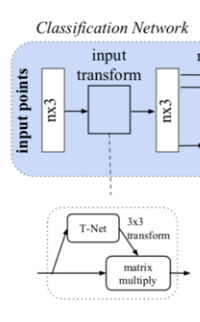)


In [ ]:
conv1 = torch.nn.Conv1d(3, 64, 1) 
h = conv1(data)

In [ ]:
h.shape

torch.Size([2, 64, 2500])

In [ ]:
class STN3d(nn.Module):
    def __init__(self):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, x):
        batchsize = x.size()[0]
        x = fn.relu(self.bn1(self.conv1(x)))
        
        x = fn.relu(self.bn2(self.conv2(x)))
        
        x = fn.relu(self.bn3(self.conv3(x)))
       
        x = torch.max(x, 2, keepdim=True)[0]
        
        x = x.view(-1, 1024)
        
        

        x = fn.relu(self.bn4(self.fc1(x)))
        x = fn.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.array([1,0,0,0,1,0,0,0,1]).astype(np.float32))).view(1,9).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, 3, 3)
        return x


In [ ]:
pnet = STN3d()
h = pnet(data)

torch.Size([2, 64, 2500])
torch.Size([2, 128, 2500])
torch.Size([2, 1024, 2500])
torch.Size([2, 1024, 1])
torch.Size([2, 1024])


In [ ]:
print(h)

tensor([[[ 0.6141,  0.2434, -0.2758],
         [ 0.2750,  1.0667, -1.0410],
         [ 0.7522,  0.0014,  0.2466]],

        [[ 1.0392,  0.2653, -0.0485],
         [-0.4570,  0.4721, -0.1100],
         [-0.2469, -0.1511,  0.9804]]], grad_fn=<ViewBackward>)


##STNkd

In [ ]:
class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k*k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024) 
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        batchsize = x.size()[0]
        x = fn.relu(self.bn1(self.conv1(x)))
        x = fn.relu(self.bn2(self.conv2(x)))
        x = fn.relu(self.bn3(self.conv3(x)))
        x = torch.max(x, 2, keepdim=True)[0]
        x = x.view(-1, 1024)

        x = fn.relu(self.bn4(self.fc1(x)))
        x = fn.relu(self.bn5(self.fc2(x)))
        x = self.fc3(x)

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1,self.k*self.k).repeat(batchsize,1)
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        x = x.view(-1, self.k, self.k)
        return x

In [ ]:
pnet1 = STNkd()
h1 = pnet1(data)

##PointNetFeat

In [ ]:
class PointNetfeat(nn.Module):
    def __init__(self, global_feat = True, feature_transform = False):
        super(PointNetfeat, self).__init__()
        self.stn = STN3d()
        self.conv1 = torch.nn.Conv1d(3, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        n_pts = x.size()[2] #点云点的个数
        trans = self.stn(x) 
        x = x.transpose(2, 1)
        x = torch.bmm(x, trans) #矩阵相乘，经过STN后的点云
        x = x.transpose(2, 1)
        x = fn.relu(self.bn1(self.conv1(x))) 

        if self.feature_transform:
            trans_feat = self.fstn(x)
            x = x.transpose(2,1)
            x = torch.bmm(x, trans_feat) # 第二次STN（64， 64）
            x = x.transpose(2,1)
        else:
            trans_feat = None

        pointfeat = x   # (2, 64, 2500)
        x = fn.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))   
        x = torch.max(x, 2, keepdim=True)[0]  #global feature
        x = x.view(-1, 1024)
        if self.global_feat:
            return x, trans, trans_feat  
        else:
            x = x.view(-1, 1024, 1).repeat(1, 1, n_pts) #每一个点都有一个global feat (2, 1024 2500)
            return torch.cat([x, pointfeat], 1), trans, trans_feat #(2, 1088, 2500)

In [ ]:
pfeat = PointNetfeat(global_feat = False)
a, b, c = pfeat(data)

In [ ]:
print(a.shape)
print(b.shape)


torch.Size([2, 1088, 2500])
torch.Size([2, 3, 3])


In [ ]:
class PointNetCls(nn.Module):
    def __init__(self, k=2, feature_transform=False):
        super(PointNetCls, self).__init__()
        self.feature_transform = feature_transform
        self.feat = PointNetfeat(global_feat=True, feature_transform=feature_transform)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.3)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()
                            
    def forward(self, x):
        x, trans, trans_feat = self.feat(x)
        x = fn.relu(self.bn1(self.fc1(x)))
        x = fn.relu(self.bn2(self.dropout(self.fc2(x))))
        x = self.fc3(x)
        return fn.log_softmax(x, dim=1), trans, trans_feat #class torch.Size([32, 5])

In [ ]:
pcls = PointNetCls()
a, b, c = pcls(data)

torch.Size([2, 64, 2500])
torch.Size([2, 128, 2500])
torch.Size([2, 1024, 2500])
torch.Size([2, 1024, 1])
torch.Size([2, 1024])


In [ ]:
print(a.shape)
print(b.shape)

torch.Size([2, 2])
torch.Size([2, 3, 3])


In [ ]:
class PointNetDenseCls(nn.Module):
    def __init__(self, k = 2, feature_transform=False):
        super(PointNetDenseCls, self).__init__()
        self.k = k
        self.feature_transform=feature_transform
        self.feat = PointNetfeat(global_feat=False, feature_transform=feature_transform)
        self.conv1 = torch.nn.Conv1d(1088, 512, 1)
        self.conv2 = torch.nn.Conv1d(512, 256, 1)
        self.conv3 = torch.nn.Conv1d(256, 128, 1)
        self.conv4 = torch.nn.Conv1d(128, self.k, 1)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.bn3 = nn.BatchNorm1d(128)

    def forward(self, x):
                           # x: [2, 3, 2500]
        batchsize = x.size()[0]
        n_pts = x.size()[2]
        x, trans, trans_feat = self.feat(x)
        x = fn.relu(self.bn1(self.conv1(x))) #[2, 512, 2500]
        print(x.shape)
        x = fn.relu(self.bn2(self.conv2(x))) #[2, 256, 2500]
        print(x.shape)
        x = fn.relu(self.bn3(self.conv3(x))) #[2, 128, 2500]
        print(x.shape)
        x = self.conv4(x) #[2, 3, 2500] k=3
        print(x.shape)
        x = x.transpose(2,1).contiguous() #[2, 2500, 3]
        print(x.shape)
        x = fn.log_softmax(x.view(-1,self.k), dim=-1) #[5000, 3]   ????
        print(x.shape)
        x = x.view(batchsize, n_pts, self.k) #[2, 2500, 3]
        print(x.shape)
        return x, trans, trans_feat   #seg torch.Size([B, 2500, k])

In [ ]:
pdense = PointNetDenseCls(k=3)
h3 = pdense(data)

torch.Size([2, 512, 2500])
torch.Size([2, 256, 2500])
torch.Size([2, 128, 2500])
torch.Size([2, 3, 2500])
torch.Size([2, 2500, 3])
torch.Size([5000, 3])
torch.Size([2, 2500, 3])


In [ ]:
def feature_transform_regularizer(trans):
    d = trans.size()[1]
    batchsize = trans.size()[0]
    I = torch.eye(d)[None, :, :] #[1, 3, 3]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2,1)) - I, dim=(1,2)))
    return loss

In [ ]:
if __name__ == '__main__':
    sim_data = Variable(torch.rand(32,3,2500))
    trans = STN3d()
    out = trans(sim_data)
    print('stn', out.size()) #stn torch.Size([32, 3, 3])
    print('loss', feature_transform_regularizer(out)) #loss tensor(2.3406, grad_fn=<MeanBackward0>)

    sim_data_64d = Variable(torch.rand(32, 64, 2500))
    trans = STNkd(k=64)
    out = trans(sim_data_64d)
    print('stn64d', out.size()) #stn64d torch.Size([32, 64, 64])
    print('loss', feature_transform_regularizer(out)) #loss tensor(130.1158, grad_fn=<MeanBackward0>)

    pointfeat = PointNetfeat(global_feat=True)
    out, _, _ = pointfeat(sim_data)
    print('global feat', out.size()) #global feat torch.Size([32, 1024])

    pointfeat = PointNetfeat(global_feat=False)
    out, _, _ = pointfeat(sim_data)
    print('point feat', out.size()) #point feat torch.Size([32, 1088, 2500]) （64维point feat + 1024维global）

    cls = PointNetCls(k = 5)
    out, _, _ = cls(sim_data)
    print('class', out.size()) #class torch.Size([32, 5])

    seg = PointNetDenseCls(k = 3)
    out, _, _ = seg(sim_data)
    print('seg', out.size()) #seg torch.Size([32, 2500, 3])

stn torch.Size([32, 3, 3])
loss tensor(2.3406, grad_fn=<MeanBackward0>)
stn64d torch.Size([32, 64, 64])
loss tensor(130.1158, grad_fn=<MeanBackward0>)
global feat torch.Size([32, 1024])
point feat torch.Size([32, 1088, 2500])
class torch.Size([32, 5])
seg torch.Size([32, 2500, 3])


pointnet 2